In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# attrition = pd.read_csv("/projects/cmpt889/uc3/Attrition - Data.csv")
# attrition = pd.read_csv("/content/drive/MyDrive/DSB/UseCase_3/Attrition_Data.csv")
attrition = pd.read_csv("/content/drive/MyDrive/shared/UseCase_3/Attrition_Data.csv")

inactive_ids = attrition.loc[attrition['Status'] == "Inactive", "New_ID"].unique().tolist()
closed_ids = attrition.loc[attrition['Status'] == "Closed", "New_ID"].unique().tolist()
inactive_closed_ids = inactive_ids + closed_ids
active_ids = [id for id in attrition["New_ID"].unique().tolist() if id not in inactive_closed_ids]

# basic data cleaning
attrition.loc[attrition['Has_Payroll'] == "Yes", "Has_Payroll"] = 1
attrition.loc[attrition['Has_Payroll'] == "yes", "Has_Payroll"] = 1
attrition.loc[attrition['Has_Payroll'] == "No", "Has_Payroll"] = 0


print(len(active_ids))
print(len(inactive_ids))
print(len(closed_ids))

8776
1575
51


In [ ]:
attrition_active = attrition.loc[attrition['New_ID'].isin(active_ids), :].copy().sort_values(['New_ID', 'Month'], ascending=[True, True]).reset_index(drop=True)
# attrition_active.head()

attrition_active['time_string'] = attrition_active['Month'].astype(str)
attrition_active['year'] = attrition_active['time_string'].str.slice(start=0, stop=4).astype(int)
attrition_active['month_int'] = attrition_active['time_string'].str.slice(start=4, stop=6).astype(int)
attrition_active['time'] = (attrition_active['year'] - 2018) * 12 + attrition_active['month_int']

# create delta features: (value at time t) - (value at time t-1)

# drop Month, time_string, year, month_int
attrition_active = attrition_active.drop(columns=['Month', 'time_string', 'month_int'])
attrition_active = attrition_active.loc[attrition_active['FUA'] >= 0, :]

# exclude those with FUA > 0.35e6 (outliers?)
# attrition_active = attrition_active.loc[(attrition_active['FUA'] < 0.35e6)]

# create delta features: value at time t - value at time t-1
# attrition_active["FUA_delta"] = attrition_active.groupby("New_ID")["FUA"].diff() / 1000
# attrition_active["FUA_delta"].fillna(0, inplace=True)

# attrition_active["Txn_delta"] = attrition_active.groupby("New_ID")["Txn"].diff()
# attrition_active["Txn_delta"].fillna(0, inplace=True)

attrition_active["FUA_delta"] = attrition_active.groupby("New_ID")["FUA"].pct_change() * 100
attrition_active["Txn_delta"] = attrition_active.groupby("New_ID")["Txn"].pct_change() * 100

attrition_active["Services_delta"] = attrition_active.groupby("New_ID")["Services"].diff()
attrition_active["Services_delta"].fillna(0, inplace=True)

attrition_active["Has_Payroll_delta"] = attrition_active.groupby("New_ID")["Has_Payroll"].diff()
attrition_active["Has_Payroll_delta"].fillna(0, inplace=True)

attrition_active["Has_Investment_delta"] = attrition_active.groupby("New_ID")["Has_Investment"].diff()
attrition_active["Has_Investment_delta"].fillna(0, inplace=True)

attrition_active["Has_VISA_delta"] = attrition_active.groupby("New_ID")["Has_VISA"].diff()
attrition_active["Has_VISA_delta"].fillna(0, inplace=True)

attrition_active["Beacon_Score_delta"] = attrition_active.groupby("New_ID")["Beacon score"].diff()
attrition_active["Beacon_Score_delta"].fillna(0, inplace=True)

# split the Age into groups
attrition_active['Age_group'] = pd.cut(attrition_active['Age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# Age_group as numeric
attrition_active['Age_group'] = attrition_active['Age_group'].astype(int)

# drop NaN and inf
attrition_active = attrition_active.replace([np.inf, -np.inf], np.nan)
attrition_active = attrition_active.dropna()

display(attrition_active.head())

,New_ID,Txn,Status,FUA,Services,Has_Payroll,Has_Investment,Has_VISA,Age,Beacon score,year,time,FUA_delta,Txn_delta,Services_delta,Has_Payroll_delta,Has_Investment_delta,Has_VISA_delta,Beacon_Score_delta,Age_group
1,aaa6489015d,34.0,Active,328370.0,8.0,1,0.0,0.0,45.0,583.0,2018,2,0.062773,-26.086957,0.0,0,0.0,0.0,0.0,4
2,aaa6489015d,38.0,Active,328380.0,8.0,1,0.0,0.0,45.0,583.0,2018,3,0.003045,11.764706,0.0,0,0.0,0.0,0.0,4
3,aaa6489015d,0.0,Active,328314.0,8.0,1,0.0,0.0,45.0,583.0,2018,4,-0.020099,-100.000000,0.0,0,0.0,0.0,0.0,4
5,aaa6489015d,0.0,Active,328246.0,8.0,1,0.0,0.0,45.0,583.0,2018,6,-0.000914,-100.000000,0.0,0,0.0,0.0,0.0,4
7,aaa6489015d,41.0,Active,328191.0,8.0,1,0.0,0.0,45.0,583.0,2018,8,-0.027416,-16.326531,0.0,0,0.0,0.0,0.0,4


In [ ]:
# Take the latest data point for each customer.
attrition_active2 = attrition_active.loc[(attrition_active['New_ID'].isin(active_ids)) & (attrition_active['time'] == 48), :].copy().sort_values(['New_ID', 'time'], ascending=[True, True]).reset_index(drop=True)

attrition_active_mean = attrition_active.loc[attrition_active['year'] == 2021, :].groupby('New_ID').agg({'FUA': 'mean', 'Txn': 'mean'}).reset_index()
attrition_active_mean.columns = ['New_ID', 'FUA_mean', 'Txn_mean']
attrition_active_mean.head()

# merge with attrition_active2
attrition_active2 = attrition_active2.merge(attrition_active_mean, on='New_ID', how='left')
display(attrition_active2.head())
# print(len(attrition_active2))

,New_ID,Txn,Status,FUA,Services,Has_Payroll,Has_Investment,Has_VISA,Age,Beacon score,...,FUA_delta,Txn_delta,Services_delta,Has_Payroll_delta,Has_Investment_delta,Has_VISA_delta,Beacon_Score_delta,Age_group,FUA_mean,Txn_mean
0,aaa6489015d,44.0,Active,328076.0,8.0,1,0.0,0.0,48.0,583.0,...,0.020121,41.935484,0.0,0,0.0,0.0,0.0,4,328120.000000,42.444444
1,aad1130444h,21.0,Active,97304.0,4.0,1,1.0,1.0,46.0,627.0,...,0.035983,23.529412,0.0,0,0.0,0.0,0.0,4,97448.166667,19.416667
2,aae309962v,29.0,Active,237206.0,4.0,1,0.0,0.0,59.0,586.0,...,0.023614,0.000000,0.0,0,0.0,0.0,0.0,5,237173.250000,20.916667
3,aaf2339482j,52.0,Active,116548.0,4.0,1,0.0,0.0,58.0,580.0,...,0.010297,15.555556,0.0,0,0.0,0.0,0.0,5,116547.833333,44.083333
4,aaf7563498g,42.0,Active,285622.0,4.0,1,0.0,0.0,66.0,625.0,...,0.019260,23.529412,0.0,0,0.0,0.0,0.0,6,285529.750000,40.750000


In [ ]:
attrition_kmeans_df = attrition_active2[['FUA_mean', 'Txn_mean', 'FUA_delta', 'Txn_delta', 'Services', 'Has_Payroll', 'Has_Investment', 'Has_VISA', 'Age_group', 'Beacon score', 'Has_Payroll_delta']].copy()

# put logs
attrition_kmeans_df['FUA_mean'] = np.log(attrition_kmeans_df['FUA_mean'])
attrition_kmeans_df['Txn_mean'] = np.log(attrition_kmeans_df['Txn_mean'])
attrition_kmeans_df['Beacon score'] = np.log(attrition_kmeans_df['Beacon score'])

# normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
attrition_kmeans_df_scaled = scaler.fit_transform(attrition_kmeans_df)

# perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
attrition_kmeans_df_pca = pca.fit_transform(attrition_kmeans_df_scaled)
attrition_kmeans_df_pca = pd.DataFrame(attrition_kmeans_df_pca)

# show variance explained
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

# exclude datapoint that has PC1 > 6
# attrition_kmeans_df_pca = attrition_kmeans_df_pca.loc[attrition_kmeans_df_pca[0] < 6, :]

# plot PC1 vs PC2 vs PC3
# import matplotlib.pyplot as plt
# plt.scatter(attrition_kmeans_df_pca[0], attrition_kmeans_df_pca[2])
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.show()


[0.22992336 0.1588644  0.10312522 0.09290078 0.09088831 0.08515002
 0.08394558 0.05366455 0.04943622 0.03212266]
0.9800210941068966


In [ ]:
# perform kmeans clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(attrition_kmeans_df_pca)
attrition_active2['k_label'] = kmeans.labels_

# count the number of customers in each cluster
attrition_active2.groupby('k_label').agg({'New_ID': 'count'}).reset_index()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,k_label,New_ID
0,0,3220
1,1,2725
2,2,1397
3,3,219


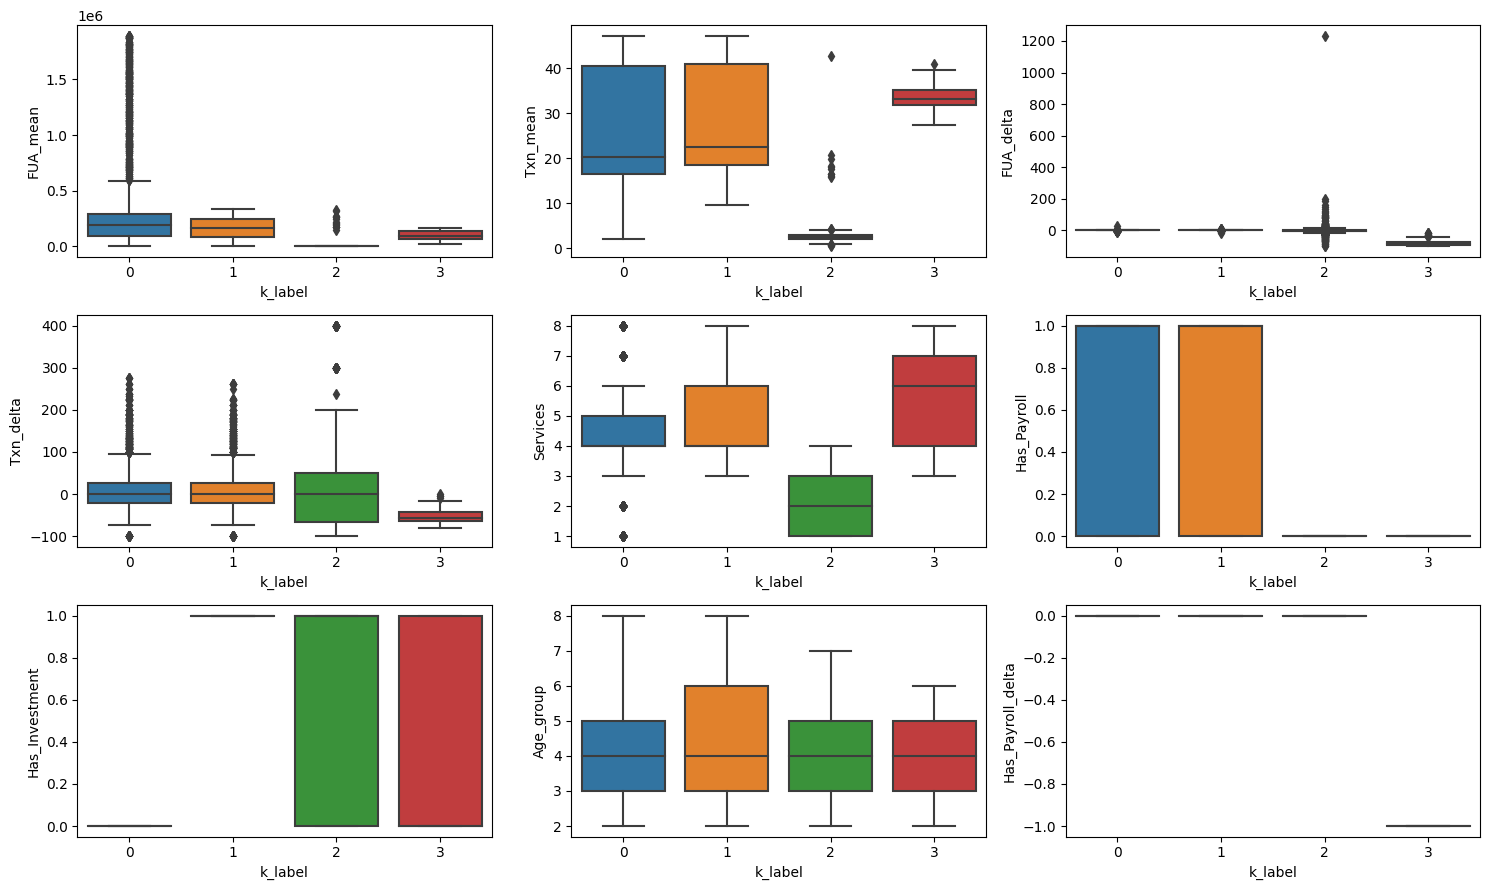

In [ ]:
# plot boxplot for each cluster
import matplotlib.pyplot as plt
import seaborn as sns

features = ['FUA_mean', 'Txn_mean', 'FUA_delta', 'Txn_delta', 'Services', 'Has_Payroll', 'Has_Investment', 'Age_group', 'Has_Payroll_delta']

fig, ax = plt.subplots(3, 3, figsize=(15, 9))
for feature in features:
    sns.boxplot(x='k_label', y=feature, data=attrition_active2, ax=ax[features.index(feature) // 3, features.index(feature) % 3])
    # plt.xlabel("Clusters")
plt.tight_layout()
plt.show()

In [ ]:
# scatterplot
# x axis: probability of attrition
# y axis: FUA mean
# color: k_label

# plt.scatter(attrition_active2['pred'], attrition_active2['FUA_mean'], c=attrition_active2['k_label'])
# plt.xlabel('probability of attrition')
# plt.ylabel('FUA mean')
# plt.show()

Text(0, 0.5, 'Count')

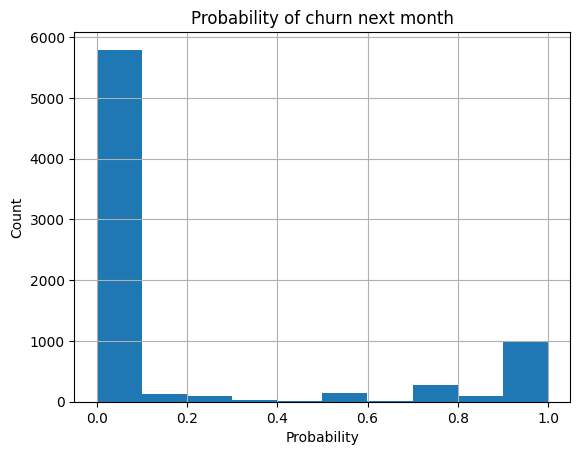

In [ ]:
# load trained gbm

import pickle
# with open('/projects/cmpt889/uc3/sonny/B02_gbm3.pkl', 'rb') as f:
#     gbm_model = pickle.load(f)
with open("/content/drive/MyDrive/shared/UseCase_3/sonny/B02_gbm3.pkl", 'rb') as f:
    gbm_model = pickle.load(f)

# make prediction
attrition_active2["pred"] = gbm_model.predict(attrition_active2[["FUA_delta", "Txn_delta", "Has_Payroll_delta", "Age_group", "time", "Services", "Beacon score"]])

# plot histogram of prediction
import matplotlib.pyplot as plt
# title : probability of churn next month
# x-axis : probability

attrition_active2['pred'].hist()
plt.title("Probability of churn next month")
plt.xlabel("Probability")
plt.ylabel("Count")

In [ ]:
# show mean pred for each cluster
attrition_active2.groupby('k_label').agg({'pred': 'mean'}).reset_index()

,k_label,pred
0,0,0.077241
1,1,0.083012
2,2,0.514825
3,3,0.996601


In [ ]:
attrition_active2['k_label'].value_counts()

0    3220
1    2725
2    1397
3     219
Name: k_label, dtype: int64

In [ ]:
# Customer evaluation: Compute expected profit per year based on assumptions:

FUA_margin = 0.02       # - We earn 2% margin on FUA per year
Txn_profit = 0.2        # - We earn $2 per 10 transactions per month
Payroll_profit = 120    # - We earn $120 per year if the customer has payroll
Investment_profit = 120 # - We earn $120 per year if the customer has investment
VISA_profit = 120       # - We earn $120 per year if the customer has VISA
Services_profit = 24    # - We earn $24 per service per years

churn_cutpoint = 0.5

attrition_active3 = attrition_active2.copy()

# merge attrition_active3 with attrition_active_mean by New_ID
attrition_active3 = attrition_active2.copy()
# attrition_active3.head()

# compute expected profit per year using the means
attrition_active3['expected_profit_year'] = (attrition_active3['FUA_mean'] * FUA_margin) + (attrition_active3['Txn_mean'] * Txn_profit)*12 + (attrition_active3['Has_Payroll'] * Payroll_profit) + (attrition_active3['Has_Investment'] * Investment_profit) + (attrition_active3['Has_VISA'] * VISA_profit) + (attrition_active3['Services'] * Services_profit)

# Based on the above assumptions, compute expected loss per year
# attrition_active3['expected_loss'] = attrition_active3['pred'] * attrition_active3['expected_profit_year']
# attrition_active3.head()

# select targets: top 300 customers with highest expected loss per year
# call_targets = attrition_active3.loc[attrition_active3['pred'] > churn_cutpoint, :].sort_values(by = ['expected_loss'], ascending= False).iloc[0:300, :].reset_index(drop=True)
# display(call_targets.tail())
# display(call_targets.describe())

# Plot
# import seaborn as sns

# horiz_value = np.min(call_targets['expected_loss'])

# # plot scatterplot of expected loss vs churn probability
# p_df = attrition_active3.copy()
# p_df['is_target'] = 0
# p_df.loc[(p_df['pred'] > churn_cutpoint) & (p_df['expected_loss'] > horiz_value), 'is_target'] = 1
# # display(p_df.head())

# sns.scatterplot(x="pred", y="expected_loss", data=p_df, alpha=0.8, s = 30, hue="is_target", palette = ["Grey", "Red"])
# plt.title("Expected loss per year vs churn probability")
# plt.xlabel("Churn probability")
# plt.ylabel("Expected loss per year")
# # draw a horizontal line at y = 1196.4

# # churn_cutpoint = np.min(call_targets['pred'])
# plt.axhline(y=horiz_value, color='r', linestyle='dashed')
# plt.axvline(x=churn_cutpoint, color='r', linestyle='dashed')
# plt.show()

In [ ]:
target_expected_profit1 = attrition_active3.loc[attrition_active3['k_label'] == 3, "expected_profit_year"].sum()

In [ ]:
more_call_targets = attrition_active3.loc[attrition_active3['k_label'] == 2, :].sort_values(by = "pred", ascending = False).head(81)
target_expected_profit2 = more_call_targets['expected_profit_year'].sum()

In [ ]:
target_profit = target_expected_profit1 + target_expected_profit2
print(target_profit)

503496.3824191919


In [ ]:
total_expected_profit = attrition_active3['expected_profit_year'].sum()
print(total_expected_profit)

31362516.10010534


In [ ]:
target_profit / total_expected_profit

0.01605408127371199

In [ ]:
# scatterplots

attrition_kmeans_df_pca2 = attrition_kmeans_df_pca.copy()
attrition_kmeans_df_pca2.columns = ["PC" + str(s) for s in range(1,11)]
attrition_kmeans_df_pca2.head()

attrition_active4 = pd.concat([attrition_active2, attrition_kmeans_df_pca2], axis= 1)
attrition_active4.head()

,New_ID,Txn,Status,FUA,Services,Has_Payroll,Has_Investment,Has_VISA,Age,Beacon score,...,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,aaa6489015d,44.0,Active,328076.0,8.0,1,0.0,0.0,48.0,583.0,...,-2.170485,0.506082,-1.108763,0.700062,-1.280219,-0.198268,0.675957,0.853838,-0.708488,-0.254463
1,aad1130444h,21.0,Active,97304.0,4.0,1,1.0,1.0,46.0,627.0,...,-0.671261,0.540240,1.423479,0.225045,-0.434686,-0.091106,0.200026,-0.859793,0.173238,0.161568
2,aae309962v,29.0,Active,237206.0,4.0,1,0.0,0.0,59.0,586.0,...,-0.712805,0.454332,-1.295657,0.383464,-1.355370,0.542561,0.163290,-0.560523,-0.351266,0.169477
3,aaf2339482j,52.0,Active,116548.0,4.0,1,0.0,0.0,58.0,580.0,...,-0.942066,0.493253,-1.129504,0.371015,-1.461979,0.358252,0.310060,-0.350916,-0.596030,0.220460
4,aaf7563498g,42.0,Active,285622.0,4.0,1,0.0,0.0,66.0,625.0,...,-1.117503,0.572537,-1.386895,-0.483216,-1.235631,0.425528,0.081642,-0.443808,-0.279866,0.222440


In [ ]:
attrition_active4.loc[attrition_active4['PC2'] > 10, ["FUA", "Txn", "Services", "Has_Payroll", "Has_Investment", "Age", "Beacon score", "Has_VISA", "FUA_delta", "Txn_delta"]]

,FUA,Txn,Services,Has_Payroll,Has_Investment,Age,Beacon score,Has_VISA,FUA_delta,Txn_delta
1178,80.0,2.0,1.0,0,0.0,36.0,717.0,0.0,1233.333333,100.0


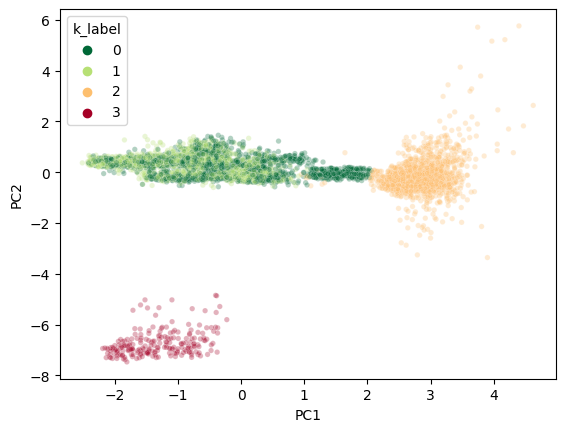

In [ ]:
attrition_active4 = attrition_active4.loc[attrition_active4['PC2'] < 10, :]
sns.scatterplot(x = attrition_active4['PC1'], y = attrition_active4['PC2'], hue = attrition_active4['k_label'], alpha = 0.3, s = 15, palette = "RdYlGn_r")
plt.show()

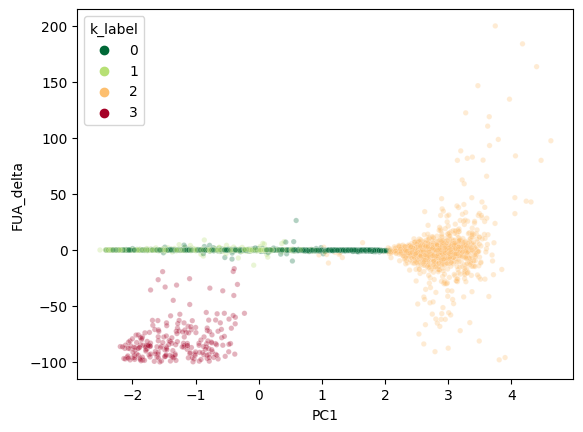

In [ ]:
sns.scatterplot(x = attrition_active4['PC1'], y = attrition_active4['FUA_delta'], hue = attrition_active4['k_label'], alpha = 0.3, s = 15, palette = "RdYlGn_r")
plt.show()

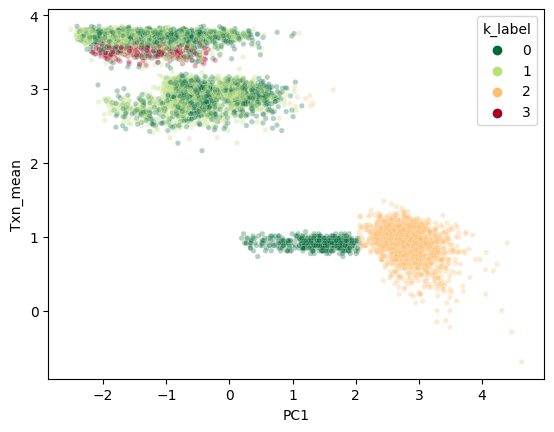

In [ ]:
sns.scatterplot(x = attrition_active4['PC1'], y = np.log(attrition_active4['Txn_mean']), hue = attrition_active4['k_label'], alpha = 0.3, s = 15, palette = "RdYlGn_r")
plt.show()

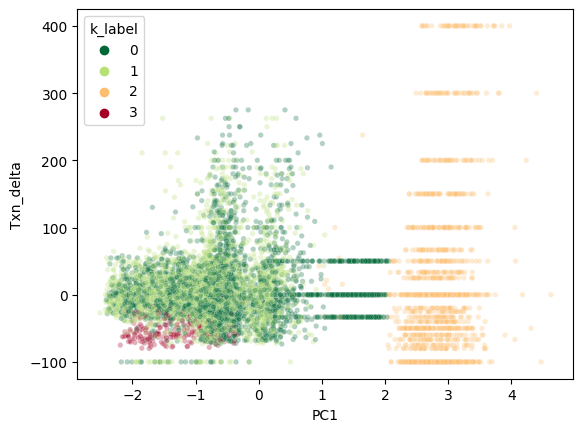

In [ ]:
sns.scatterplot(x = attrition_active4['PC1'], y = attrition_active4['Txn_delta'], hue = attrition_active4['k_label'], alpha = 0.3, s = 15, palette = "RdYlGn_r")
plt.show()